In [1]:
from notebook_setup.with_matplotlib import *
from IPython.display import display
init_nb()
toggle_code_button()

# Temperature dependence of the optical constants of gold

This is a straightforward import of the data for gold published in the following extract from Dr M. Otter's thesis:

> Otter, M., 1961. Temperaturabhängigkeit der optischen Konstanten massiver Metalle. Z. Physik 161, 539–549. [doi:10.1007/BF01341551](http://dx.doi.org/10.1007/BF01341551)

The numbers were lifted from the graph using [Engauge Digitizer](http://markummitchell.github.io/engauge-digitizer/) version 9.6 from EPEL.

In [2]:
df_k2_minus_n2 = pd.read_csv('data/Otter Au k²-n².csv', index_col='x')
df_2nk = pd.read_csv('data/Otter Au 2nk.csv', index_col='x')

In [3]:
new_index = np.unique(np.concatenate([df_2nk.index, df_k2_minus_n2.index, np.arange(450, 640)]))
k2_minus_n2 = df_k2_minus_n2.reindex(new_index).interpolate(method='cubic')
twice_nk = df_2nk.reindex(new_index).interpolate(method='cubic')
k2_minus_n2.index.name = 'λ'
twice_nk.index.name = 'λ'

In [4]:
n = (1.0j * twice_nk - k2_minus_n2)**(1/2)
n = n.iloc[1:-1] # The first and last values won't have been properly interpolated!

The values look reasonable:

In [5]:
n_at_532 = n.loc[532]
display(n_at_532)

10C         (0.420344664361+2.30689822201j)
310C        (0.571820297993+2.31396700115j)
570C        (0.679865957001+2.32808676058j)
920C        (0.845649642034+2.37020875029j)
1063C       (0.914823146115+2.34860084702j)
1063C fl     (1.21639271912+2.64132871535j)
Name: 532.0, dtype: complex128

Now lets' calculate some spectra... (ignoring the thermal lens effect!!)

In [6]:
import scattnlay
from collections import OrderedDict

radius = 25
n_medium = 1.33301

lambda_vac = np.arange(450, 640)
refractive_indices = n.loc[lambda_vac]

sigma_ext = OrderedDict()
sigma_abs = OrderedDict()
sigma_sca = OrderedDict()

for temp in refractive_indices.columns:
    k = 2 * np.pi * n_medium / lambda_vac
    x = np.array([radius * k]).T
    aunp_n = refractive_indices[temp]
    m = np.array([aunp_n/n_medium]).T
    (terms, Qext, Qsca, Qabs, Qbk, Qpr, g, Albedo, S1, S2) = scattnlay.scattnlay(x, m)
    sigma_ext[temp] = Qext * x[:,-1]**2 * np.pi * k**(-2)
    sigma_abs[temp] = Qabs * x[:,-1]**2 * np.pi * k**(-2)
    sigma_sca[temp] = Qsca * x[:,-1]**2 * np.pi * k**(-2)

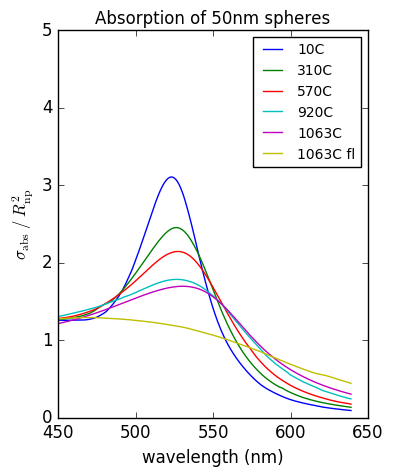

In [14]:
fig = plt.figure(figsize=(4,5))

for (temp, sigmata) in sigma_abs.items():
    plt.plot(lambda_vac, sigmata / 50**2, label=temp)
    
plt.legend(loc='best', fontsize=10)
plt.xlabel('wavelength (nm)')
plt.ylabel('$\sigma_\mathrm{abs}\;/\;R_\mathrm{np}^2$')
plt.ylim(0, 5)
plt.title('Absorption of 50nm spheres', fontsize=12)
None

In [15]:
fig.savefig('out/fig-abs_spectra_temp.png')

Let's get a quick estimate of the broadening to see if this is compatible with Paul's thesis

In [ ]:
for (temp, sigmata) in sigma_abs.items():
    # find maximum
    maxidx = sigmata.argmax()
    maxval = sigmata[maxidx]
    halfmaxval = maxval / 2
    # where do we cross the half maximum?
    halfmaxidx = maxidx + np.argwhere((sigmata[maxidx:] < halfmaxval))[0]
    width = halfmaxidx - maxidx
    width_inverse_nm = 1/lambda_vac[maxidx] - 1/lambda_vac[halfmaxidx]
    width_eV = width_inverse_nm * 1239.842
    print('for {} : from {} (max) to {} half max is {} eV'.format(temp, lambda_vac[maxidx], lambda_vac[halfmaxidx], width_eV))
    #print(temp, 'from' width, width_eV)
    

In [ ]:
print('slope', (0.2527755-0.2304136) / (920-310))

That doesn't *quite* fit with the 0.1 meV/K listed in Paul's thesis, but it's in the right ballpark.

There may be some useful corrections for small particles that I'm not aware of that could make this better, e.g. a model for surface melting


In [ ]:
n.to_csv('out/Otter_Au_complex_n.csv')
n.to_pickle('out/Otter_Au_complex_n.pickle')